# TiDE model for melt pool temperature

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")
    
import numpy as np
from tqdm import tqdm
from TiDE import TideModule, quantile_loss
import pickle

import matplotlib.pyplot as plt
import time
import copy

from moving_average import moving_average_1d

cuda is available


In [2]:
df_all = pd.read_csv('merged_df_2_99.csv')
df_all.shape

(610615, 11)

In [3]:
df_all = df_all.dropna()
df_all.shape

(610514, 11)

In [4]:
loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

Text(0, 0.5, 'melt pool temperature')

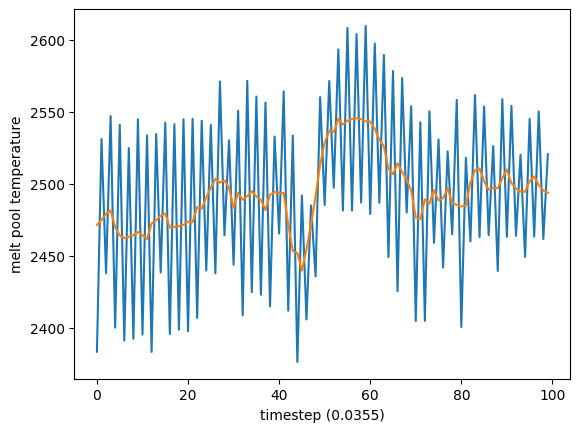

In [10]:
plt.plot(mp_temp_raw[100:200])
plt.plot(mp_temp[100:200])
plt.xlabel("timestep (0.0355)")
plt.ylabel("melt pool temperature")


In [12]:
# stack input array
x_original_scale = np.concatenate((loc_X,loc_Y,loc_Z,dist_X,dist_Y,scan_spd,laser_on_off,laser_power),axis=1)
y_original_scale = mp_temp


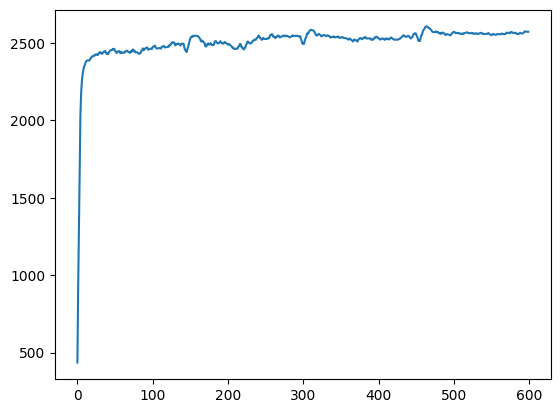

In [13]:
plt.plot(mp_temp[:600])

### Scaler for input and output

In [14]:
x_max = np.max(x_original_scale,0).reshape(1,-1) # shape = [1,7]
x_min = np.min(x_original_scale,0).reshape(1,-1) # shape = [1,7]

y_max = np.max(y_original_scale,0).reshape(1,-1) # shape = [1,1]
y_min = np.min(y_original_scale,0).reshape(1,-1) # shape = [1,1]

In [15]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [16]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

### Knit data to the required format for training input and output

In [17]:
cutoff_ratio = 0.9
cutoff_index = int(np.round(cutoff_ratio*x_s.shape[0]))

x_s_train = x_s[:cutoff_index, :]
y_s_train = y_s[:cutoff_index, :]

x_s_val = x_s[cutoff_index:, :]
y_s_val = y_s[cutoff_index:, :]

# slice data w.r.t given window and horizon size

window = 50
P = 50


# ====================== training set =============================================

x_s_train_covariates = np.empty((cutoff_index- P - window , window+P,x_s.shape[1]))
y_s_train_past       = np.empty((cutoff_index- P - window , window,y_s.shape[1]))
y_s_train_target     = np.empty((cutoff_index- P - window , P,y_s.shape[1]))

for i in tqdm(range(window,cutoff_index-P)):
    x_s_train_covariates_piece = np.expand_dims(x_s_train[i-window:i+P,:],axis=0)
    x_s_train_covariates[i-window,:,:] = x_s_train_covariates_piece
    
    y_s_train_past_piece = np.expand_dims(y_s_train[i-window:i,:], axis=0)
    y_s_train_past[i-window,:,:] = y_s_train_past_piece
    
    y_s_train_target_piece = np.expand_dims(y_s_train[i:i+P,:],axis=0)
    y_s_train_target[i-window,:,:] = y_s_train_target_piece
    

    
# ===================== validation set ============================================
val_cutoff = x_s.shape[0] - cutoff_index

x_s_val_covariates = np.empty((val_cutoff- P - window , window+P,x_s.shape[1]))
y_s_val_past       = np.empty((val_cutoff- P - window , window,y_s.shape[1]))
y_s_val_target     = np.empty((val_cutoff- P - window , P,y_s.shape[1]))

for i in tqdm(range(window,val_cutoff-P)):
    x_s_val_covariates_piece = np.expand_dims(x_s_val[i-window:i+P,:],axis=0)
    x_s_val_covariates[i-window,:,:] = x_s_val_covariates_piece
    
    y_s_val_past_piece = np.expand_dims(y_s_val[i-window:i,:], axis=0)
    y_s_val_past[i-window,:,:] = y_s_val_past_piece
    
    y_s_val_target_piece = np.expand_dims(y_s_val[i:i+P,:],axis=0)
    y_s_val_target[i-window,:,:] = y_s_val_target_piece

100%|██████████| 60951/60951 [00:00<00:00, 64437.05it/s]


In [18]:
input_past = torch.tensor(np.concatenate((y_s_train_past,x_s_train_covariates[:,:window,:]),axis=2),dtype=torch.float32).to(device)
input_future = torch.tensor(x_s_train_covariates[:,-P:,:], dtype=torch.float32).to(device)
input_target = torch.tensor(y_s_train_target,dtype=torch.float32).to(device)

val_past = torch.tensor(np.concatenate((y_s_val_past,x_s_val_covariates[:,:window,:]),axis=2),dtype=torch.float32).to(device)
val_future = torch.tensor(x_s_val_covariates[:,-P:,:], dtype=torch.float32).to(device)
val_target = torch.tensor(y_s_val_target,dtype=torch.float32).to(device)

Val_in = [val_past, val_future,None]

print(f"input past shape:{input_past.shape}, input future shape:{input_future.shape}, input target shape:{input_target.shape}")
print(f"val past shape:{val_past.shape}, val future shape:{val_future.shape}, val target shape:{val_target.shape}")

input past shape:torch.Size([549363, 50, 9]), input future shape:torch.Size([549363, 50, 8]), input target shape:torch.Size([549363, 50, 1])
val past shape:torch.Size([60951, 50, 9]), val future shape:torch.Size([60951, 50, 8]), val target shape:torch.Size([60951, 50, 1])


### Setup training model

In [19]:
output_dim = 1
future_cov_dim = 8

TiDE_MP = TideModule(
        input_dim = output_dim + future_cov_dim,
        output_dim = output_dim,
        future_cov_dim = future_cov_dim,
        static_cov_dim = 0,
        input_chunck_length = window,
        output_chunk_length = P,
        nr_params = 3,
        num_encoder_layers = 1,
        num_decoder_layers = 1,
        decoder_output_dim = 16,
        hidden_size = 128,
        temporal_decoder_hidden = 32,
        temporal_width_past = 4,
        temporal_width_future = 4,
        use_layer_norm = True,
        dropout = 0.2,
    ).to(device)

# Define optimizer, loss function, and metrics
optimizer = torch.optim.Adam(TiDE_MP.parameters(),lr=0.001,weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
criterion = quantile_loss
#criterion = torch.nn.MSELoss()
num_epoch = 200




In [20]:
# Create DataLoader for training data
train_dataset = TensorDataset(input_past, input_future,input_target)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

best_model = None
best_validation_loss = float("inf")

save_train_loss = np.zeros(num_epoch)
save_val_loss = np.zeros(num_epoch)

for epoch in range(num_epoch):
    for input_past, input_future, input_target in train_loader:
        x_in = [input_past, input_future, None]

        TiDE_MP.train()
        optimizer.zero_grad()
        output = TiDE_MP(x_in)
        quantiles = [0.05, 0.5, 0.95]
        loss = criterion(output,input_target,quantiles)
        #loss = criterion(output,input_target)
        loss.backward()
        optimizer.step()

    TiDE_MP.eval()
    val_out = TiDE_MP(Val_in)
    val_loss = criterion(val_out,val_target,quantiles)
    #val_loss = criterion(val_out,Val_target)

    if val_loss < best_validation_loss:
        best_val_loss = val_loss
        best_model = TiDE_MP.state_dict()
    
    save_train_loss[epoch] = loss
    save_val_loss[epoch] = val_loss

    scheduler.step()
    
    if epoch % 1 == 0:
        print(f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}")


# Save the model (state_dict) after training
# save DNN parameters
path = ''
sys_params = dict()
sys_params["x_max"] = x_max
sys_params["x_min"] = x_min
sys_params["y_max"] = y_max
sys_params["y_min"] = y_min
sys_params["model"] = TiDE_MP
sys_params["P"] = P
sys_params["window"] = window
pickle.dump(sys_params, open(path + 'TiDE_params_single_track_square_MV_2.pkl', 'wb'))


Epoch = 0, Train loss = 0.0471, Val loss = 0.0456
Epoch = 1, Train loss = 0.0269, Val loss = 0.0252
Epoch = 2, Train loss = 0.0196, Val loss = 0.0167
Epoch = 3, Train loss = 0.0188, Val loss = 0.0145
Epoch = 4, Train loss = 0.0151, Val loss = 0.0149
Epoch = 5, Train loss = 0.0127, Val loss = 0.0141
Epoch = 6, Train loss = 0.0143, Val loss = 0.0132
Epoch = 7, Train loss = 0.0208, Val loss = 0.0152
Epoch = 8, Train loss = 0.0137, Val loss = 0.0133
Epoch = 9, Train loss = 0.0160, Val loss = 0.0140
Epoch = 10, Train loss = 0.0149, Val loss = 0.0133
Epoch = 11, Train loss = 0.0195, Val loss = 0.0129
Epoch = 12, Train loss = 0.0097, Val loss = 0.0129
Epoch = 13, Train loss = 0.0141, Val loss = 0.0129
Epoch = 14, Train loss = 0.0144, Val loss = 0.0131
Epoch = 15, Train loss = 0.0148, Val loss = 0.0127
Epoch = 16, Train loss = 0.0137, Val loss = 0.0127
Epoch = 17, Train loss = 0.0161, Val loss = 0.0131
Epoch = 18, Train loss = 0.0134, Val loss = 0.0132
Epoch = 19, Train loss = 0.0122, Val loss

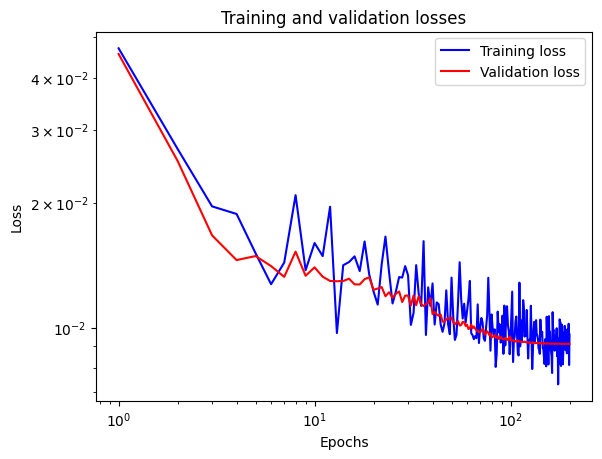

In [21]:
# Plot loss
loss = save_train_loss
val_loss = save_val_loss
epochs=range(1,len(loss)+1)
plt.figure()
plt.semilogy(epochs, loss,'b', label='Training loss')
plt.semilogy(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
#plt.savefig('lossLSTM32.png')
plt.show()

forward time = 0.020432472229003906


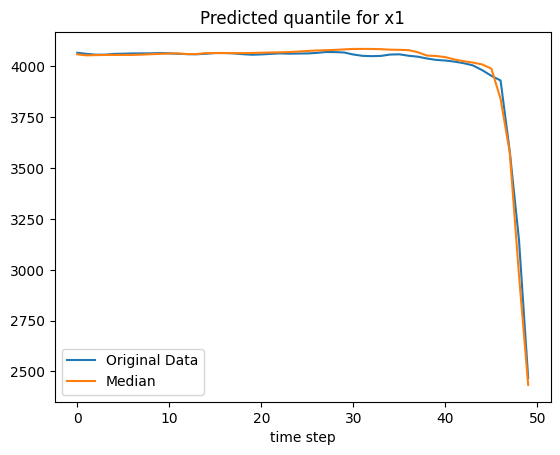

In [22]:
item = 1060 # Select the index for visualizing the results using validation data

x_plot_past = val_past[item,:,:].unsqueeze(0)
x_plot_future = val_future[item,:,:].unsqueeze(0)
x_plot_val = [x_plot_past, x_plot_future, None]
y_plot_val = val_target[item,:,:].unsqueeze(0)

TiDE_MP.eval()

time1 = time.time()
y_hat = TiDE_MP(x_plot_val)
time2 = time.time()
print(f"forward time = {time2-time1}")

# plot x1
plt.figure()
y_true_original = scaler.inv_scaler_y(y_plot_val.to("cpu")[:,:,0].squeeze().numpy())
plt.plot(y_true_original[0,:],label="Original Data")

y_hat_original = scaler.inv_scaler_y(y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy())
plt.plot(y_hat_original[0,:],label="Median")

# y_hat_ub_original = scaler.inv_scaler_y(y_hat[:,:,0,0].squeeze().detach().to("cpu").numpy())
# plt.plot(y_hat_ub_original[0,:],label="Lower quantile")

# y_hat_lb_original = scaler.inv_scaler_y(y_hat[:,:,0,2].squeeze().detach().to("cpu").numpy())
# plt.plot(y_hat_lb_original[0,:],label="Upper quantile")

plt.title('Predicted quantile for x1')
plt.xlabel('time step')

#plt.ylim([3000,4000])
# plt.xlim([0,19])

# plt.fill_between(range(P),
#                  y1=y_hat_ub_original[0,:],
#                  y2=y_hat_lb_original[0,:],
#                  alpha=0.2, color='gray')
plt.legend()



### Evaluation

In [23]:
def sMAPE(y_true,y_hat):
    MAPE_ind = 100* np.mean(np.abs((y_true - y_hat) / (np.abs(y_true)+np.abs(y_hat))))
    return MAPE_ind

def SSE_compute(y_true, y_hat):
    return np.sum((y_true - y_hat)**2)

# Main code for eval
MAPE_x1 = np.empty((val_past.shape[0]))

SSE_x1 = 0
SSE_x2 = 0


for item in range(val_past.shape[0]):
    x_past = val_past[item,:,:].unsqueeze(0)
    x_future = val_future[item,:,:].unsqueeze(0)
    x_val = [x_past, x_future, None]
    y_val = val_target[item,:,:].unsqueeze(0)
    y_hat = TiDE_MP(x_val)
    # sMAPE
    MAPE_x1[item] = (sMAPE(y_val.to("cpu")[:,:,0].squeeze().numpy(), y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy()))

    # RMSE
    SSE_x1 = SSE_x1 + SSE_compute(y_val.to("cpu")[:,:,0].squeeze().numpy(), y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy())



n_item = val_past.shape[0] * val_past.shape[1]
RRMSE_x1 = np.sqrt(np.sum(SSE_x1)/n_item/np.var(y_s_val[:,0]))*100

MAPE_x1 = np.mean(MAPE_x1)

print(f"MAPE_x1 = {MAPE_x1:.2f}%")   
print(f"RRMSE_x1 = {RRMSE_x1:.2f}")  

MAPE_x1 = 1.19%
RRMSE_x1 = 4.24
